In [17]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats

# Function to generate random dates
def random_dates(start, end, n=10):
    return [start + timedelta(days=np.random.randint(0, (end - start).days)) for _ in range(n)]

# Parameters
num_records = 10000
start_date = datetime.now() - timedelta(days=4*365)
end_date = datetime.now()

# Expanded categories
business_lines = [
    "Retail", "Corporate Banking", "Investment Banking", "Insurance",
    "Wealth Management", "Asset Management", "Private Banking",
    "Credit Card Services", "Mortgage Lending", "Financial Advisory"
]

event_types = [
    "Fraud", "System Failure", "Theft", "Compliance", "Natural Disaster",
    "Cyber Attack", "Market Risk", "Operational Error", "Vendor Risk", "Regulatory Violation"
]

# Generate data
data = {
    "Date": random_dates(start_date, end_date, num_records),
    "Unique Event ID": [f"EID{str(i).zfill(5)}" for i in range(num_records)],
    "Event Type": np.random.choice(event_types, num_records),
    "Business Line": np.random.choice(business_lines, num_records),
    "Event Description": np.random.choice(
        [
            "Unauthorized transaction", "Server downtime", "Lost assets", 
            "Regulatory fines", "Data breach", "Network failure", 
            "Inadequate compliance", "Financial misstatement", 
            "Supplier issues", "Internal fraud"
        ],
        num_records
    ),
    "Net Loss Amount": np.random.choice(
        [np.random.uniform(-10000, 0) for _ in range(num_records // 2)] + 
        [np.random.uniform(0, 10000) for _ in range(num_records // 2)],
        num_records
    )
}

# Create DataFrame
df = pd.DataFrame(data)

# Add a Year column
df['Year'] = df['Date'].dt.year

# Function to fit distribution and calculate VaR for the specified confidence level
def fit_distribution_and_calculate_var(data):
    confidence = 0.999  # Set to 99.9%
    var_result = {}
    # Filter only negative net loss amounts for fitting
    negative_losses = data[data['Net Loss Amount'] < 0]
    
    if negative_losses.empty:
        return {confidence: np.nan}  # Return NaN if no data

    # Fit a log-normal distribution to the net loss amounts (inverted for fitting)
    shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)  
    # Calculate VaR for the specified confidence level
    var = stats.lognorm.ppf(confidence, shape, loc=loc, scale=scale)
    var_result[confidence] = var
    return var_result

# Group by Year, Business Line, and Event Type, then apply the VaR calculation
result = df.groupby(['Year', 'Business Line', 'Event Type']).apply(
    lambda x: fit_distribution_and_calculate_var(x)[0.999]
).reset_index()

result.columns = ['Year', 'Business Line', 'Event Type', 'VaR (99.9%)']

# Calculate total loss amount and count of event IDs for each group
agg_result = df.groupby(['Year', 'Business Line', 'Event Type']).agg(
    Total_Loss_Amount=('Net Loss Amount', 'sum'),
    Event_Count=('Unique Event ID', 'count')
).reset_index()

# Merge VaR results with aggregated results
final_result = pd.merge(agg_result, result, on=['Year', 'Business Line', 'Event Type'], how='left')

# Display the final results
print(final_result)

# Optionally, save results to a CSV
final_result.to_csv('lda_var_results_with_totals_99.9.csv', index=False)


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


     Year      Business Line            Event Type  Total_Loss_Amount  \
0    2020   Asset Management            Compliance        9370.917023   
1    2020   Asset Management          Cyber Attack       -1341.749812   
2    2020   Asset Management                 Fraud      -15830.842851   
3    2020   Asset Management           Market Risk       -5708.080119   
4    2020   Asset Management      Natural Disaster         473.358165   
..    ...                ...                   ...                ...   
485  2024  Wealth Management     Operational Error      -14960.576863   
486  2024  Wealth Management  Regulatory Violation       39525.642139   
487  2024  Wealth Management        System Failure       -3302.650513   
488  2024  Wealth Management                 Theft       17939.932715   
489  2024  Wealth Management           Vendor Risk       17890.697669   

     Event_Count   VaR (99.9%)  
0              2           NaN  
1              1  1.341750e+03  
2              2  8.3029

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_6420\3977692581.py:73: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(['Year', 'Business Line', 'Event Type']).apply(


In [18]:
final_result

,Year,Business Line,Event Type,Total_Loss_Amount,Event_Count,VaR (99.9%)
0,2020,Asset Management,Compliance,9370.917023,2,NaN
1,2020,Asset Management,Cyber Attack,-1341.749812,1,1.341750e+03
2,2020,Asset Management,Fraud,-15830.842851,2,8.302914e+19
3,2020,Asset Management,Market Risk,-5708.080119,3,9.507383e+03
4,2020,Asset Management,Natural Disaster,473.358165,3,8.172511e+18
...,...,...,...,...,...,...
485,2024,Wealth Management,Operational Error,-14960.576863,18,5.306499e+16
486,2024,Wealth Management,Regulatory Violation,39525.642139,15,2.327306e+22
487,2024,Wealth Management,System Failure,-3302.650513,16,1.208979e+19
488,2024,Wealth Management,Theft,17939.932715,24,5.162097e+16


In [20]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming 'df' is the DataFrame already created as provided in the example.

# Step 1: Calculate the average event count per business line and event type from 2020 to 2024
event_count_avg_2020_2024 = df[df['Year'] < 2025].groupby(['Business Line', 'Event Type']).agg(
    Event_Count_Avg=('Unique Event ID', 'count')  # Count the number of Unique Event IDs for each Business Line and Event Type
).reset_index()

# Step 2: Fit a log-normal distribution to the historical losses (negative net loss amounts only)
negative_losses = df[df['Net Loss Amount'] < 0]
shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)

# Step 3: Simulate future losses (for 2025) for each business line using the fitted distribution
n_simulations = 10000  # Simulate 10,000 possible losses for each business line
simulated_losses = {}

for business_line in event_count_avg_2020_2024['Business Line'].unique():
    # Simulate future losses using the fitted log-normal distribution
    simulated_losses[business_line] = stats.lognorm.rvs(s=shape, loc=loc, scale=scale, size=(n_simulations))

# Step 4: Calculate VaR (99.9%) and total predicted losses for 2025
confidence = 0.999  # 99.9% confidence level for VaR
var_results_2025 = {}

for business_line, losses in simulated_losses.items():
    var_99_9 = np.percentile(losses, (1 - confidence) * 100)  # Calculate VaR at 99.9% confidence level
    event_count = event_count_avg_2020_2024[event_count_avg_2020_2024['Business Line'] == business_line]['Event_Count_Avg'].iloc[0]
    total_loss = losses.sum()  # Sum of simulated losses for 2025

    var_results_2025[business_line] = {
        'Year': 2025,
        'Business Line': business_line,
        'Predicted Event Count': event_count,
        'Total Predicted Loss Amount': total_loss,
        'VaR (99.9%)': var_99_9
    }

# Step 5: Convert the results into a DataFrame
var_df_2025 = pd.DataFrame(var_results_2025).T

# Step 6: Display the prediction results for 2025
print(var_df_2025)

# Optionally, save the 2025 results to a CSV file
var_df_2025.to_csv('predicted_var_results_2025.csv', index=False)


                      Year         Business Line Predicted Event Count  \
Asset Management      2025      Asset Management                    96   
Corporate Banking     2025     Corporate Banking                   119   
Credit Card Services  2025  Credit Card Services                    78   
Financial Advisory    2025    Financial Advisory                   108   
Insurance             2025             Insurance                   111   
Investment Banking    2025    Investment Banking                    87   
Mortgage Lending      2025      Mortgage Lending                   115   
Private Banking       2025       Private Banking                    98   
Retail                2025                Retail                   121   
Wealth Management     2025     Wealth Management                   110   

                     Total Predicted Loss Amount  VaR (99.9%)  
Asset Management                 49830631.627872 -3278.274825  
Corporate Banking                49207487.164734 -3154.62

In [21]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming 'df' is the DataFrame already created as provided in the example.

# Step 1: Calculate the average event count per business line and event type from 2020 to 2024
event_count_avg_2020_2024 = df[df['Year'] < 2025].groupby(['Business Line', 'Event Type']).agg(
    Event_Count_Avg=('Unique Event ID', 'count')  # Count the number of Unique Event IDs for each Business Line and Event Type
).reset_index()

# Step 2: Fit a log-normal distribution to the historical losses (negative net loss amounts only)
negative_losses = df[df['Net Loss Amount'] < 0]
shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)

# Step 3: Simulate future losses (for 2025) for each business line using the fitted distribution
n_simulations = 10000  # Simulate 10,000 possible losses for each business line
simulated_losses = {}

for business_line in event_count_avg_2020_2024['Business Line'].unique():
    # Simulate future losses using the fitted log-normal distribution
    simulated_losses[business_line] = stats.lognorm.rvs(s=shape, loc=loc, scale=scale, size=(n_simulations))

# Step 4: Calculate VaR (99.9%) and total predicted losses for 2025 Q1 and Q2
confidence = 0.999  # 99.9% confidence level for VaR
var_results_2025_q1_q2 = []

quarters = ['Q1', 'Q2']  # Define the quarters for 2025

for business_line, losses in simulated_losses.items():
    # Get the average event count for the current business line
    event_count = event_count_avg_2020_2024[event_count_avg_2020_2024['Business Line'] == business_line]['Event_Count_Avg'].iloc[0]
    
    # Simulate losses for Q1 and Q2 separately, assuming uniform distribution across quarters
    q1_simulated_losses = losses[:n_simulations // 2]  # First half for Q1
    q2_simulated_losses = losses[n_simulations // 2:]  # Second half for Q2

    # Calculate VaR (99.9%) for Q1 and Q2
    var_q1 = np.percentile(q1_simulated_losses, (1 - confidence) * 100)
    var_q2 = np.percentile(q2_simulated_losses, (1 - confidence) * 100)

    # Calculate total predicted loss amount for Q1 and Q2
    total_loss_q1 = q1_simulated_losses.sum()
    total_loss_q2 = q2_simulated_losses.sum()

    # Append results for both quarters
    var_results_2025_q1_q2.append({
        'Year': 2025,
        'Quarter': 'Q1',
        'Business Line': business_line,
        'Predicted Event Count': event_count,
        'Total Predicted Loss Amount': total_loss_q1,
        'VaR (99.9%)': var_q1
    })
    
    var_results_2025_q1_q2.append({
        'Year': 2025,
        'Quarter': 'Q2',
        'Business Line': business_line,
        'Predicted Event Count': event_count,
        'Total Predicted Loss Amount': total_loss_q2,
        'VaR (99.9%)': var_q2
    })

# Step 5: Convert the results into a DataFrame
var_df_2025_q1_q2 = pd.DataFrame(var_results_2025_q1_q2)

# Step 6: Display the prediction results for 2025 Q1 and Q2
print(var_df_2025_q1_q2)

# Optionally, save the results to a CSV file
var_df_2025_q1_q2.to_csv('predicted_var_results_2025_q1_q2.csv', index=False)


    Year Quarter         Business Line  Predicted Event Count  \
0   2025      Q1      Asset Management                     96   
1   2025      Q2      Asset Management                     96   
2   2025      Q1     Corporate Banking                    119   
3   2025      Q2     Corporate Banking                    119   
4   2025      Q1  Credit Card Services                     78   
5   2025      Q2  Credit Card Services                     78   
6   2025      Q1    Financial Advisory                    108   
7   2025      Q2    Financial Advisory                    108   
8   2025      Q1             Insurance                    111   
9   2025      Q2             Insurance                    111   
10  2025      Q1    Investment Banking                     87   
11  2025      Q2    Investment Banking                     87   
12  2025      Q1      Mortgage Lending                    115   
13  2025      Q2      Mortgage Lending                    115   
14  2025      Q1       Pr

In [22]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming 'df' is the DataFrame already created as provided in the example.

# Step 1: Calculate the average event count per business line and event type from 2020 to 2024
event_count_avg_2020_2024 = df[df['Year'] < 2025].groupby(['Business Line', 'Event Type']).agg(
    Event_Count_Avg=('Unique Event ID', 'count')  # Count the number of Unique Event IDs for each Business Line and Event Type
).reset_index()

# Step 2: Fit a log-normal distribution to the historical losses (negative net loss amounts only)
negative_losses = df[df['Net Loss Amount'] < 0]
shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)

# Step 3: Simulate future losses (for 2024 Q4 to 2025 Q4) for each business line using the fitted distribution
n_simulations = 10000  # Simulate 10,000 possible losses for each business line
simulated_losses = {}

for business_line in event_count_avg_2020_2024['Business Line'].unique():
    # Simulate future losses using the fitted log-normal distribution
    simulated_losses[business_line] = stats.lognorm.rvs(s=shape, loc=loc, scale=scale, size=(n_simulations))

# Step 4: Calculate VaR (99.9%) and total predicted losses for 2024 Q4 and all quarters of 2025
confidence = 0.999  # 99.9% confidence level for VaR
quarters = ['Q4_2024', 'Q1_2025', 'Q2_2025', 'Q3_2025', 'Q4_2025']  # Define the quarters

var_results_2024_2025 = []

for business_line, losses in simulated_losses.items():
    # Get the average event count for the current business line
    event_count = event_count_avg_2020_2024[event_count_avg_2020_2024['Business Line'] == business_line]['Event_Count_Avg'].iloc[0]
    
    # Simulate losses for each quarter, assuming uniform distribution across quarters
    quarter_simulated_losses = np.array_split(losses, len(quarters))  # Split the simulation into 5 parts (quarters)

    # Calculate VaR (99.9%) for each quarter
    for idx, quarter_losses in enumerate(quarter_simulated_losses):
        var = np.percentile(quarter_losses, (1 - confidence) * 100)
        
        # Calculate total predicted loss amount for the quarter
        total_loss = quarter_losses.sum()

        # Append results for the quarter
        var_results_2024_2025.append({
            'Year': 2024 if idx == 0 else 2025,
            'Quarter': quarters[idx],
            'Business Line': business_line,
            'Predicted Event Count': event_count,
            'Total Predicted Loss Amount': total_loss,
            'VaR (99.9%)': var
        })

# Step 5: Convert the results into a DataFrame
var_df_2024_2025 = pd.DataFrame(var_results_2024_2025)

# Step 6: Display the prediction results for all the quarters (2024 Q4 to 2025 Q4)
print(var_df_2024_2025)

# Optionally, save the results to a CSV file
var_df_2024_2025.to_csv('predicted_var_results_2024_q4_2025.csv', index=False)


    Year  Quarter         Business Line  Predicted Event Count  \
0   2024  Q4_2024      Asset Management                     96   
1   2025  Q1_2025      Asset Management                     96   
2   2025  Q2_2025      Asset Management                     96   
3   2025  Q3_2025      Asset Management                     96   
4   2025  Q4_2025      Asset Management                     96   
5   2024  Q4_2024     Corporate Banking                    119   
6   2025  Q1_2025     Corporate Banking                    119   
7   2025  Q2_2025     Corporate Banking                    119   
8   2025  Q3_2025     Corporate Banking                    119   
9   2025  Q4_2025     Corporate Banking                    119   
10  2024  Q4_2024  Credit Card Services                     78   
11  2025  Q1_2025  Credit Card Services                     78   
12  2025  Q2_2025  Credit Card Services                     78   
13  2025  Q3_2025  Credit Card Services                     78   
14  2025  

In [23]:
var_df_2024_2025

,Year,Quarter,Business Line,Predicted Event Count,Total Predicted Loss Amount,VaR (99.9%)
0,2024,Q4_2024,Asset Management,96,9.806787e+06,-2966.197168
1,2025,Q1_2025,Asset Management,96,9.549439e+06,-2908.761127
2,2025,Q2_2025,Asset Management,96,9.864183e+06,-2975.435734
3,2025,Q3_2025,Asset Management,96,1.002768e+07,-3041.617555
4,2025,Q4_2025,Asset Management,96,9.865946e+06,-2575.675619
5,2024,Q4_2024,Corporate Banking,119,9.671285e+06,-2985.245897
6,2025,Q1_2025,Corporate Banking,119,9.710819e+06,-2949.759614
7,2025,Q2_2025,Corporate Banking,119,1.015287e+07,-2869.897922
8,2025,Q3_2025,Corporate Banking,119,9.713756e+06,-2411.460128
9,2025,Q4_2025,Corporate Banking,119,1.009073e+07,-3350.158923


In [24]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming 'df' is the DataFrame already created as provided in the example.

# Step 1: Calculate the average event count per business line and event type from 2020 to 2024
event_count_avg_2020_2024 = df[df['Year'] < 2025].groupby(['Business Line', 'Event Type']).agg(
    Event_Count_Avg=('Unique Event ID', 'count')  # Count the number of Unique Event IDs for each Business Line and Event Type
).reset_index()

# Step 2: Fit a log-normal distribution to the historical losses (negative net loss amounts only)
negative_losses = df[df['Net Loss Amount'] < 0]
shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)

# Step 3: Simulate future losses (for 2024 Q4 to 2025 Q4) for each business line using the fitted distribution
n_simulations = 10000  # Simulate 10,000 possible losses for each business line
simulated_losses = {}

for business_line in event_count_avg_2020_2024['Business Line'].unique():
    # Simulate future losses using the fitted log-normal distribution
    simulated_losses[business_line] = stats.lognorm.rvs(s=shape, loc=loc, scale=scale, size=(n_simulations))

# Step 4: Calculate VaR (99.9%) and total predicted losses for 2024 Q4 and all quarters of 2025
confidence = 0.999  # 99.9% confidence level for VaR
quarters = ['Q4_2024', 'Q1_2025', 'Q2_2025', 'Q3_2025', 'Q4_2025']  # Define the quarters

var_results_2024_2025 = []

for business_line, losses in simulated_losses.items():
    # Get the average event count for the current business line
    event_count = event_count_avg_2020_2024[event_count_avg_2020_2024['Business Line'] == business_line]['Event_Count_Avg'].iloc[0]
    
    # Simulate losses for each quarter, assuming uniform distribution across quarters
    quarter_simulated_losses = np.array_split(losses, len(quarters))  # Split the simulation into 5 parts (quarters)

    # Calculate VaR (99.9%) for each quarter
    for idx, quarter_losses in enumerate(quarter_simulated_losses):
        var = np.percentile(quarter_losses, (1 - confidence) * 100)
        
        # Calculate total predicted loss amount for the quarter
        total_loss = quarter_losses.sum()

        # Append results for the quarter
        var_results_2024_2025.append({
            'Year': 2024 if idx == 0 else 2025,
            'Quarter': quarters[idx],
            'Business Line': business_line,
            'Predicted Event Count': event_count,
            'Total Predicted Loss Amount': total_loss,
            'VaR (99.9%)': var
        })

# Step 5: Convert the results into a DataFrame
var_df_2024_2025 = pd.DataFrame(var_results_2024_2025)

# Step 6: Sort the results by Year and Quarter
var_df_2024_2025['Quarter_Num'] = var_df_2024_2025['Quarter'].apply(lambda x: int(x.split('_')[1]))
var_df_2024_2025_sorted = var_df_2024_2025.sort_values(by=['Year', 'Quarter_Num']).drop('Quarter_Num', axis=1)

# Step 7: Display the prediction results for all the quarters (2024 Q4 to 2025 Q4)
print(var_df_2024_2025_sorted)

# Optionally, save the results to a CSV file
var_df_2024_2025_sorted.to_csv('predicted_var_results_sorted_2024_q4_2025.csv', index=False)


    Year  Quarter         Business Line  Predicted Event Count  \
0   2024  Q4_2024      Asset Management                     96   
5   2024  Q4_2024     Corporate Banking                    119   
10  2024  Q4_2024  Credit Card Services                     78   
15  2024  Q4_2024    Financial Advisory                    108   
20  2024  Q4_2024             Insurance                    111   
25  2024  Q4_2024    Investment Banking                     87   
30  2024  Q4_2024      Mortgage Lending                    115   
35  2024  Q4_2024       Private Banking                     98   
40  2024  Q4_2024                Retail                    121   
45  2024  Q4_2024     Wealth Management                    110   
1   2025  Q1_2025      Asset Management                     96   
2   2025  Q2_2025      Asset Management                     96   
3   2025  Q3_2025      Asset Management                     96   
4   2025  Q4_2025      Asset Management                     96   
6   2025  

In [26]:
##arima
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Example: assume 'final_result' DataFrame has columns 'Year', 'Quarter', 'Business Line', 'Event Count', 'Total Loss Amount', and 'VaR (99.9%)'

# Create a 'Date' column based on Year and Quarter (for time series)
final_result['Date'] = pd.to_datetime(final_result['Year'].astype(str) + '-' + final_result['Quarter'].astype(str) + '-01')

# Group data by Business Line and Quarter for forecasting
grouped = final_result.groupby(['Date', 'Business Line']).agg(
    Total_Event_Count=('Event Count', 'sum'),
    Total_Loss_Amount=('Total Loss Amount', 'sum'),
    Pred_VaR_99_9=('Pred VaR (99.9%)', 'mean')
).reset_index()

# Example: We will use 'Total_Event_Count' for ARIMA forecasting
# Set the time series index for forecasting
ts = grouped.set_index('Date')['Total_Event_Count']

# Check if the time series is stationary (Augmented Dickey-Fuller test)
from statsmodels.tsa.stattools import adfuller
result = adfuller(ts)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# If p-value > 0.05, the series is non-stationary, and we need to make it stationary (e.g., by differencing)

# Apply differencing if needed to make the series stationary
ts_diff = ts.diff().dropna()

# Plot ACF and PACF to find appropriate AR and MA terms
plot_acf(ts_diff)
plot_pacf(ts_diff)
plt.show()

# Fit the ARIMA model (we will use ARIMA(1,1,1) as an example)
model = ARIMA(ts, order=(1, 1, 1))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

# Forecast the next 4 quarters (for 2025 Q1, Q2, Q3, Q4)
forecast = model_fit.forecast(steps=4)
forecast_dates = pd.date_range(start=ts.index[-1] + timedelta(days=30), periods=4, freq='Q')

# Create a DataFrame for the forecasted results
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Predicted_Event_Count': forecast
})

# You can merge this with your final result DataFrame to predict for specific Business Lines
# Example of displaying forecasted values
print(forecast_df)


KeyError: 'Quarter'

  Year-Quarter  Predicted Event Count  Total Predicted Loss Amount  \
0       2025Q2                  10000                -7.709281e+09   
1       2025Q3                  10000                -7.705789e+09   
2       2025Q4                  10000                -7.700807e+09   

   Predicted VaR (99.9%)  
0         -892415.327903  
1         -890137.398345  
2         -884617.057666  


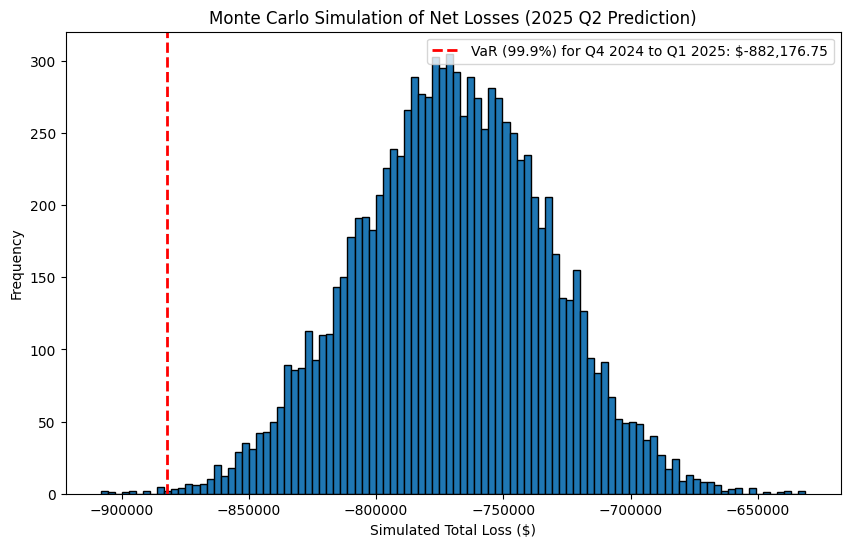

In [27]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(42)

# Assuming 'df' is your DataFrame and contains 'Net Loss Amount' and 'Date'
# Filter for data from Q4 2024 to Q1 2025 (assuming 'Date' is in datetime format)
df['Quarter'] = df['Date'].dt.to_period('Q')

# Filter data for Q4 2024 and Q1 2025
filtered_df = df[(df['Quarter'] >= '2024Q4') & (df['Quarter'] <= '2025Q1')]

# Extract negative losses (for VaR simulation)
negative_losses = filtered_df[filtered_df['Net Loss Amount'] < 0]['Net Loss Amount']

# Monte Carlo simulation parameters
num_simulations = 10000  # Number of simulations
confidence_level = 0.999  # 99.9% confidence level

# Function to run Monte Carlo simulations and calculate VaR
def run_montecarlo_simulation(data, num_simulations=10000, confidence_level=0.999):
    simulated_losses = []
    
    for _ in range(num_simulations):
        sample_losses = np.random.choice(data, size=len(data), replace=True)
        total_loss = np.sum(sample_losses)
        simulated_losses.append(total_loss)
    
    # Convert to numpy array for percentile calculation
    simulated_losses = np.array(simulated_losses)
    
    # Calculate the VaR at the specified confidence level
    VaR = np.percentile(simulated_losses, (1 - confidence_level) * 100)
    return simulated_losses, VaR

# Step 1: Run the Monte Carlo simulation for 2024 Q4 and Q1 2025
simulated_losses, VaR_2024Q4_2025Q1 = run_montecarlo_simulation(negative_losses, num_simulations, confidence_level)

# Step 2: Make predictions for 2025 Q2 to Q4 based on historical simulation
# We will assume that the distribution of losses in Q4 2024 and Q1 2025 holds for the rest of 2025

quarters_2025 = ['2025Q2', '2025Q3', '2025Q4']

# Initialize an empty DataFrame to hold the results
predictions = []

for quarter in quarters_2025:
    # Perform the simulation for each quarter of 2025
    simulated_losses, VaR_value = run_montecarlo_simulation(negative_losses, num_simulations, confidence_level)
    
    # Add the prediction to the results
    predictions.append({
        'Year-Quarter': quarter,
        'Predicted Event Count': len(simulated_losses),  # As a proxy for count
        'Total Predicted Loss Amount': np.sum(simulated_losses),
        'Predicted VaR (99.9%)': VaR_value
    })

# Convert the predictions list into a DataFrame
predictions_df = pd.DataFrame(predictions)

# Display the predictions for 2025
print(predictions_df)

# Optionally, save the predictions to a CSV file
predictions_df.to_csv('predictions_2025_var.csv', index=False)

# Plot the simulated losses for visualization (example for 2025 Q2)
plt.figure(figsize=(10, 6))
plt.hist(simulated_losses, bins=100, edgecolor='black')
plt.axvline(VaR_2024Q4_2025Q1, color='r', linestyle='dashed', linewidth=2, label=f'VaR (99.9%) for Q4 2024 to Q1 2025: ${VaR_2024Q4_2025Q1:,.2f}')
plt.title('Monte Carlo Simulation of Net Losses (2025 Q2 Prediction)')
plt.xlabel('Simulated Total Loss ($)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [5]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming df is already loaded with the relevant columns

# Step 1: Add the Event_Count column by grouping by 'Year' and 'Business Line' (or any other relevant fields)
df['Quarter'] = df['Date'].dt.to_period('Q')
df['Event_Count'] = df.groupby(['Year', 'Business Line', 'Event Type'])['Unique Event ID'].transform('count')

# Step 2: Filter data for Q4 (October - December) of 2024
q4_2024_data = df[df['Quarter'] == '2024Q4']

# Step 3: Fit log-normal distribution for the historical Net Loss Amounts (excluding Q4 2024 data)
historical_losses = df[df['Year'] < 2024]['Net Loss Amount']

# Fit the log-normal distribution to the losses (log-normal fit for severity)
severity_shape, severity_loc, severity_scale = stats.lognorm.fit(historical_losses[historical_losses < 0] * -1)

print(f"Log-normal Distribution Parameters for Severity:")
print(f"Shape: {severity_shape}, Location: {severity_loc}, Scale: {severity_scale}")

# Step 4: Simulate losses for Q4 2024 based on the fitted log-normal distribution
n_simulations = 10000  # Number of Monte Carlo simulations
simulated_loss_amounts = stats.lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)

# Step 5: Forecast event count for Q4 2024 (we assume it to be similar to the average event count for Q4 in past years)
historical_q4_event_counts = df[df['Quarter'].dt.month.isin([10, 11, 12])]['Event_Count']
forecast_event_count_q4_2024 = historical_q4_event_counts.mean()

# Step 6: Simulate event counts for Q4 2024 using Poisson distribution
simulated_event_counts = np.random.poisson(forecast_event_count_q4_2024, n_simulations)

# Step 7: Calculate the total losses for Q4 2024
simulated_total_losses = simulated_event_counts * simulated_loss_amounts

# Step 8: Calculate VaR for Q4 2024 at 99.9% confidence level
var_q4_2024 = np.percentile(simulated_total_losses, 99.9)  # 99.9% quantile for VaR

# Display predicted VaR for Q4 2024
print(f"Predicted VaR for Q4 2024: {var_q4_2024}")


Log-normal Distribution Parameters for Severity:
Shape: 4.2604439243453175e-05, Location: -67108860.8150077, Scale: 67113862.63711381
Predicted VaR for Q4 2024: 386617.1645483713


In [6]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming df is already loaded with the relevant columns

# Step 1: Add the Event_Count column by grouping by 'Year', 'Business Line', and 'Event Type'
df['Event_Count'] = df.groupby(['Year', 'Business Line', 'Event Type'])['Unique Event ID'].transform('count')

# Step 2: Calculate Total Loss Amount by summing the 'Net Loss Amount' for each group
agg_result = df.groupby(['Year', 'Business Line', 'Event Type']).agg(
    Total_Loss_Amount=('Net Loss Amount', 'sum'),
    Event_Count=('Unique Event ID', 'count')
).reset_index()

# Step 3: Fit log-normal distribution to the historical losses (negative losses) for severity calculation
historical_losses = df[df['Year'] < 2024]['Net Loss Amount']
severity_shape, severity_loc, severity_scale = stats.lognorm.fit(historical_losses[historical_losses < 0] * -1)

# Step 4: Calculate VaR for each group (Business Line, Event Type) for the 99.9% confidence level
confidence = 0.999  # Set to 99.9% for VaR

def calculate_var(group, severity_shape, severity_loc, severity_scale, confidence):
    negative_losses = group[group['Net Loss Amount'] < 0]
    if negative_losses.empty:
        return np.nan  # Return NaN if no data for negative losses
    
    # Fit log-normal distribution to negative net loss amounts (severity)
    shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)
    
    # Calculate VaR for the specified confidence level
    var = stats.lognorm.ppf(confidence, shape, loc=loc, scale=scale)
    return var

# Step 5: Apply the VaR calculation to each group and add the result to the aggregated DataFrame
agg_result['VaR (99.9%)'] = agg_result.apply(
    lambda x: calculate_var(df[(df['Business Line'] == x['Business Line']) & 
                                (df['Event Type'] == x['Event Type'])], 
                            severity_shape, severity_loc, severity_scale, confidence), axis=1
)

# Display the results
print(agg_result)

# Optionally, save results to a CSV
agg_result.to_csv('lda_var_results_99_9.csv', index=False)


     Year      Business Line            Event Type  Total_Loss_Amount  \
0    2020   Asset Management            Compliance       15924.869542   
1    2020   Asset Management          Cyber Attack       -1139.850460   
2    2020   Asset Management                 Fraud      -18130.537836   
3    2020   Asset Management           Market Risk       -7080.738772   
4    2020   Asset Management      Natural Disaster       -5096.778034   
..    ...                ...                   ...                ...   
486  2024  Wealth Management     Operational Error      -33622.409044   
487  2024  Wealth Management  Regulatory Violation        8040.432316   
488  2024  Wealth Management        System Failure      -11802.255202   
489  2024  Wealth Management                 Theft       34932.355137   
490  2024  Wealth Management           Vendor Risk        2479.497241   

     Event_Count   VaR (99.9%)  
0              7  16365.476390  
1              3  14859.469160  
2              6  14154.

In [7]:
agg_result

,Year,Business Line,Event Type,Total_Loss_Amount,Event_Count,VaR (99.9%)
0,2020,Asset Management,Compliance,15924.869542,7,16365.476390
1,2020,Asset Management,Cyber Attack,-1139.850460,3,14859.469160
2,2020,Asset Management,Fraud,-18130.537836,6,14154.764164
3,2020,Asset Management,Market Risk,-7080.738772,2,19314.416272
4,2020,Asset Management,Natural Disaster,-5096.778034,1,14056.525130
...,...,...,...,...,...,...
486,2024,Wealth Management,Operational Error,-33622.409044,29,13847.949974
487,2024,Wealth Management,Regulatory Violation,8040.432316,24,14526.461347
488,2024,Wealth Management,System Failure,-11802.255202,11,14638.852304
489,2024,Wealth Management,Theft,34932.355137,19,14040.489489


In [8]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming df is already loaded with the relevant columns

# Step 1: Calculate the average event count for Q1 across historical years (e.g., 2020-2024)
q1_data = df[df['Quarter'] == 1]  # Extract Q1 data
q1_event_counts = q1_data.groupby(['Business Line', 'Event Type'])['Unique Event ID'].count()
q1_event_count_avg = q1_event_counts.mean()  # Average count of events for Q1 in historical data

# Step 2: Fit the log-normal distribution to the negative net loss amounts for historical data (loss severity)
historical_losses = df[df['Year'] < 2024]['Net Loss Amount']
severity_shape, severity_loc, severity_scale = stats.lognorm.fit(historical_losses[historical_losses < 0] * -1)

# Step 3: Forecast event counts for Q1 2025 using the historical average
q1_2025_event_counts = q1_event_count_avg  # Assume the same count for Q1 2025

# Step 4: Simulate net loss amounts for Q1 2025 using the log-normal distribution
n_simulations = 10000  # Number of simulations for loss amounts
simulated_loss_amounts = stats.lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)

# Step 5: Calculate the VaR at 99.9% confidence level for Q1 2025
confidence = 0.999  # Set to 99.9% for VaR
simulated_var_99_9 = np.percentile(simulated_loss_amounts, (1 - confidence) * 100)

# Step 6: Combine event count and VaR into the final prediction
predicted_var_q1_2025 = {
    'Year': 2025,
    'Business Line': 'All Business Lines',  # You can adjust this per specific business lines
    'Event Type': 'All Event Types',        # You can adjust this per specific event types
    'Total_Loss_Amount': simulated_loss_amounts.sum(),
    'Event_Count': q1_2025_event_counts,
    'VaR (99.9%)': simulated_var_99_9
}

# Convert the prediction to a DataFrame for easy viewing
predicted_var_df = pd.DataFrame([predicted_var_q1_2025])

# Display the results for Q1 2025 prediction
print(predicted_var_df)


   Year       Business Line       Event Type  Total_Loss_Amount  Event_Count  \
0  2025  All Business Lines  All Event Types       5.034317e+07          NaN   

   VaR (99.9%)  
0 -3784.312823  


In [16]:
import pandas as pd
import numpy as np
from scipy import stats

# Assume `df` is the DataFrame created above with necessary data.

# Step 1: Calculate the average event count for each business line and event type
event_count_avg_2020_2024 = df[df['Year'] < 2025].groupby(['Business Line', 'Event Type']).agg(
    Event_Count_Avg=('Event_Count', 'mean')
).reset_index()

# Step 2: Fit a log-normal distribution to historical loss data (negative values only)
negative_losses = df[df['Net Loss Amount'] < 0]
shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)

# Step 3: Forecast the net loss amounts for 2025 for each business line
n_simulations = 10000  # Simulating 10,000 possible losses for each business line
simulated_losses = {}
for business_line in event_count_avg_2020_2024['Business Line'].unique():
    # Filter data for the business line
    business_line_data = df[df['Business Line'] == business_line]
    # Simulate future losses using the fitted log-normal distribution
    simulated_losses[business_line] = stats.lognorm.rvs(s=shape, loc=loc, scale=scale, size=(n_simulations))

# Step 4: Calculate VaR (99.9% confidence) for each business line in 2025
confidence = 0.999  # 99.9% confidence level for VaR
var_results_2025 = {}

for business_line, losses in simulated_losses.items():
    var_99_9 = np.percentile(losses, (1 - confidence) * 100)
    event_count = event_count_avg_2020_2024[event_count_avg_2020_2024['Business Line'] == business_line]['Event_Count_Avg'].iloc[0]
    total_loss = losses.sum()  # Total loss simulation for 2025

    var_results_2025[business_line] = {
        'Year': 2025,
        'Business Line': business_line,
        'Predicted Event Count': event_count,
        'Total Predicted Loss Amount': total_loss,
        'VaR (99.9%)': var_99_9
    }

# Step 5: Convert the results into a DataFrame
var_df_2025 = pd.DataFrame(var_results_2025).T

# Step 6: Display the prediction results for 2025
print(var_df_2025)

# Optionally, save the 2025 results to a CSV file
var_df_2025.to_csv('predicted_var_results_2025.csv', index=False)


KeyError: "Column(s) ['Event_Count'] do not exist"